# SCOAP3 country calculation of contributors ratio per institution

Authors: Pablo Iriarte (pablo.iriarte@unige.ch), Jean-Blaise Claivaz (jean-blaise.claivaz@unige.ch) & Eric Silva Quintana (eric.silvaquintana@unige.ch), University of Geneva Library, Switzerland

* First version: 10.03.2019
* Last update: 11.04.2024
* Licence: CC BY 4.0

Notebook created to import records from the SCOAP3 repository in order to calculate the relative weight/importance of each institution of a given country for a specific range of years. A list of existing affiliations mapped to acronyms is needed.

It is composed of 4 parts:

1. Importing metadata/records
2. Parsing and processing the metadata
3. Mapping affiliations to acronyms
4. Final calculation and results


## Initial values and parameters

In [1]:
# Dependencies
import os
import pandas as pd
import json
import requests
from tqdm import tqdm

# Name of the country as appearing in SCOAP3 metadata
country = 'Switzerland'

# Time range (YYYY)
starting_year = '2023'
ending_year = '2023'

# SCOAP3 repository API request
# Example 1: Search of all records for a country and a time span:
# searchurl = 'https://repo.scoap3.org/api/records/?q=country:' + country + '&year=' + starting_year + '--' + ending_year
# Example 2: Same as example 1, but without records affiliated with CERN:
searchurl = 'https://repo.scoap3.org/api/records/?q=country:((NOT CERN) AND ' + country + ')&year=' + starting_year + '--' + ending_year

# Input file containing the mapping from affiliations existing in metadata to a distinct code (of your choice)
# Example: "AEC-LHEP, University of Bern, Bern, Switzerland" -> "UNIBE"
# The file extension can be .xlsx (excel) or .tsv (tab separated)
# The file must contain two columns with the header names "affiliation_value" and "acronym"
mapping_file = 'affiliations_mapping.xlsx'

# Output folder structure
data_import_folder = 'imports/import_' + country + '_' + starting_year + '_' + ending_year
data_parsed_folder = 'parsed'
results_folder = 'results'

# Output files containing data extracted and the results of calculation and processing
publications = data_parsed_folder + '/' + country + '_' + starting_year + '_' + ending_year + '_publications.tsv'
affiliations = data_parsed_folder + '/' + country + '_' + starting_year + '_' + ending_year + '_affiliations.tsv'

# Output file containing the ratios and percentages by institution
# The file extension can be .xlsx (excel) or .tsv (tab separated)
results_ratios = results_folder + '/' + country + '_' + starting_year + '_' + ending_year + '_ratios.xlsx'

# Output file containing the affiliations of the country that are not yet mapped. You may ignore affiliations that are irrelevant
# for your calculations, but relevant affiliations must be mapped to an acronym and added in the mapping file
# The file extension can be .xlsx (excel) or .tsv (tab separated)
affiliations_not_mapped = results_folder + '/' + country + '_' + starting_year + '_' + ending_year + '_affiliations_not_mapped.xlsx'

# Output file containing list of publication for each mapped institutions
# The file extension can be .xlsx (excel) or .tsv (tab separated)
publications_by_institution = results_folder + '/' + country + '_' + starting_year + '_' + ending_year + '_publications_by_institution.xlsx'

# Switch for launching the import from SCOAP3 repository [0,1]. Set to 0 if the import of records is already done
do_import = 1

# Switch for launching the data processing [0,1]. Set to 0 if the parsing of data is already done
do_parse = 1

# Switch for launching the affiliation mapping [0,1]. Set to 0 if the mapping is mapping already done
do_map = 1

C:\Users\iriarte\AppData\Local\Continuum\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (5.1.0) doesn't match a supported version!
  RequestsDependencyWarning)


## 1. Importing records from the SCOAP3 repository

### Folder creation

In [2]:
if not os.path.exists(data_import_folder):
    os.makedirs(data_import_folder)

In [3]:
if not os.path.exists(data_parsed_folder):
    os.makedirs(data_parsed_folder)

In [4]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

### JSON files import

In [5]:
# Get the total number of records and record from the first page
def get_total(url):
    headers = {'Accept': 'application/json'}
    url_next = ''
    resp = requests.get(url, headers=headers)

    if (resp.status_code == 200) :
        # import
        data_json = resp.json()
        # save individual records
        for hit in data_json['hits']['hits']:
            publication_id = hit['id']
            with open(data_import_folder + '/' + str(publication_id) + '.json', 'w', encoding='utf-8') as f:
                f.write(json.dumps(hit))
                f.close()
                    
        if 'next' in data_json['links'] :
            url_next = data_json['links']['next']
        if 'total' in data_json['hits'] :
            total = data_json['hits']['total']
            print (str(total) + ' documents found for ' + country + ' between ' + starting_year + ' and ' + ending_year)
            print ('####################################')
            print ('Page 0 - DONE')
            return(total, url_next)
        else :
            print ('0 document found for ' + country + ' between ' + starting_year + ' and ' + ending_year)
            print ('Page 1 - DONE')
            return(0, url_next)
    else :
        print ('0 document found for ' + country + ' between ' + starting_year + ' and ' + ending_year)
        print ('Page 1 - ERROR - ' + url)
        return(0, url_next)

In [6]:
# Get record from the next pages
def import_json(url, page):
    headers = {'Accept': 'application/json'}
    resp = requests.get(url, headers=headers)

    if (resp.status_code == 200) :
        # import
        data_json = resp.json()
        # save individual records
        for hit in data_json['hits']['hits']:
            publication_id = hit['id']
            with open(data_import_folder + '/' + str(publication_id) + '.json', 'w', encoding='utf-8') as f:
                f.write(json.dumps(hit))
                f.close()
       
        if 'next' in data_json['links'] :
            url_next = data_json['links']['next']
            print ('Page ' + str(page) + ' - DONE')
            return(url_next)
        else :
            print ('Page ' + str(page) + ' - DONE')
            print ('End of pages')
            return('')
    else :
        print ('Page ' + str(page) + ' - ERROR - ' + url)
        return('')

In [7]:
if (do_import == 1) :
    page_counter = 1
    # first page import
    total, next_page_url = get_total(searchurl)
    if ((int(total) > 0) & (next_page_url != '')) :
        # next pages
        while (next_page_url != ''):
            next_page_url = import_json(next_page_url, page_counter)
            page_counter = page_counter + 1

238 documents found for Switzerland between 2023 and 2023
####################################
Page 0 - DONE
Page 1 - DONE
Page 2 - DONE
Page 3 - DONE
Page 4 - DONE
Page 5 - DONE
Page 6 - DONE
Page 7 - DONE
Page 8 - DONE
Page 9 - DONE
Page 10 - DONE
Page 11 - DONE
Page 12 - DONE
Page 13 - DONE
Page 14 - DONE
Page 15 - DONE
Page 16 - DONE
Page 17 - DONE
Page 18 - DONE
Page 19 - DONE
Page 20 - DONE
Page 21 - DONE
Page 22 - DONE
Page 23 - DONE
End of pages


## 2. Parsing the imported records

### Parsing the imported JSON files and storing the publications and affiliations data

In [8]:
# Preprocessing of the publications
if (do_parse == 1):
    # creation of file
    file_publications = open(publications, mode='w', encoding='utf-8')
   
    # write first line
    file_publications.write('publication_id\tpublication_year\tpublication_doi\tauthors_nb\taffiliations_nb\n')

    # look for records in the folder of imported files
    files = os.listdir(data_import_folder)
    nb_records = 0
    
    # loop on files
    for file in tqdm(files):        
        # open the json files
        with open(data_import_folder + '/' + file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if not data['metadata']:
                break
            nb_records = nb_records + 1
            authors_n = 0
            affiliations_n = 0
            publication_id = data['id']
            if ('year' in data['metadata']) :
                publication_year = data['metadata']['year']
            if ('dois' in data['metadata']) :
                publication_doi = data['metadata']['dois'][0]['value']
            else:
                publication_doi = ''
            if ('authors' in data['metadata']):
                for hit_author in data['metadata']['authors']:
                    authors_n = authors_n + 1
                    if ('affiliations' in hit_author):
                        for author_affiliation in hit_author['affiliations']:
                            affiliations_n = affiliations_n + 1
            # write the data in file
            file_publications.write(str(publication_id))
            file_publications.write('\t')
            file_publications.write(publication_year)
            file_publications.write('\t')
            file_publications.write(publication_doi)
            file_publications.write('\t')
            file_publications.write(str(authors_n))
            file_publications.write('\t')
            file_publications.write(str(affiliations_n))
            file_publications.write('\n')
        f.close()
    file_publications.close()

100%|███████████████████████████████████████████████████████████████████████████████| 238/238 [00:02<00:00, 102.22it/s]


In [9]:
if (do_parse == 1):
    print('Number of publications parsed: ' + str(nb_records))

Number of publications parsed: 238


In [10]:
# Preprocessing of the affiliations
if (do_parse == 1):
    # creation of file
    file_affiliations = open(affiliations, mode='w', encoding='utf-8')
   
    # write first line
    file_affiliations.write('publication_id\tauthor_id\taffiliation_id\tratio\taffiliation_country\taffiliation_value\n')

    # look for records in the folder of imported files
    files = os.listdir(data_import_folder)
     
    # ids
    ratio_total = 0
    nb_records = 0

    # loop on files
    for file in tqdm(files):        
        # open of json file
        with open(data_import_folder + '/' + file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if not data['metadata']:
                break
            # parsing publications
            nb_records = nb_records + 1
            authors_n = 0
            affiliations_n = 0
            publication_id = data['id']
            authors_id = ''
            authors_n = 0
            authors_i = 0
            authors_ratio = 0
            affiliations_id = ''
            affiliations_n = 0
            affiliations_i = 0
            affiliations_ratio = 0
            ratio = 0
            affiliation_country = ''
            affiliation_value = ''

            if ('year' in data['metadata']) :
                publication_year = data['metadata']['year']
            if ('authors' in data['metadata']):
                authors_i = 0
                for hit_author in data['metadata']['authors']:
                    authors_n = authors_n + 1
                authors_ratio = 1/authors_n
                for hit_author in data['metadata']['authors']:
                    authors_i = authors_i + 1
                    authors_id = str(publication_id) + '-' + str(authors_i)
                    if ('affiliations' in hit_author):
                        affiliations_n = 0
                        affiliations_i = 0
                        affiliations_ratio = 0
                        ratio = 0
                        for author_affiliation in hit_author['affiliations']:
                            affiliations_n = affiliations_n + 1
                        affiliations_ratio = 1/affiliations_n
                        ratio = authors_ratio * affiliations_ratio
                        for author_affiliation in hit_author['affiliations']:
                            ratio_total = ratio_total + ratio
                            affiliation_country = ''
                            affiliation_value = ''
                            affiliations_i = affiliations_i + 1
                            affiliations_id = str(authors_id) + '-' + str(affiliations_i)
                            if ('country' in author_affiliation):
                                affiliation_country = author_affiliation['country']
                            if ('value' in author_affiliation):
                                affiliation_value = author_affiliation['value']
                            # write the data in file
                            file_affiliations.write(str(publication_id))
                            file_affiliations.write('\t')
                            file_affiliations.write(authors_id)
                            file_affiliations.write('\t')
                            file_affiliations.write(affiliations_id)
                            file_affiliations.write('\t')
                            file_affiliations.write(str(ratio))
                            file_affiliations.write('\t')
                            file_affiliations.write(str(affiliation_country))
                            file_affiliations.write('\t')
                            file_affiliations.write(str(affiliation_value))
                            file_affiliations.write('\n')
                    else:
                        # print('ERROR ' + str(publication_id) + ' affiliation missing')
                        affiliations_n = 0
                        affiliations_i = 0
                        affiliations_ratio = 0
                        ratio = authors_ratio
                        ratio_total = ratio_total + ratio
                        affiliation_country = ''
                        affiliation_value = ''
                        affiliations_i = affiliations_i + 1
                        affiliations_id = str(authors_id) + '-' + str(affiliations_i)
                        # write the data in file
                        file_affiliations.write(str(publication_id))
                        file_affiliations.write('\t')
                        file_affiliations.write(authors_id)
                        file_affiliations.write('\t')
                        file_affiliations.write(affiliations_id)
                        file_affiliations.write('\t')
                        file_affiliations.write(str(ratio))
                        file_affiliations.write('\t')
                        file_affiliations.write(str(affiliation_country))
                        file_affiliations.write('\t')
                        file_affiliations.write(str(affiliation_value))
                        file_affiliations.write('\n')
        f.close()
    file_affiliations.close()

100%|██████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 2366.16it/s]


In [11]:
if (do_parse == 1):
    print('publications parsed: ' + str(nb_records))

publications parsed: 238


In [12]:
# Intermediary check
if (do_parse == 1):
    # check the ratio -> it should be equal or closed to the number of publications
    print('ratio total: ' + str(ratio_total))

ratio total: 238.00000000000583


## 3. Mapping of the affiliations to acronyms

In [13]:
# Data stored in files are injected in 2 dataframes
df_publications = pd.read_csv(publications, sep='\t')
df_affiliations = pd.read_csv(affiliations, sep='\t')

In [14]:
df_publications

,publication_id,publication_year,publication_doi,authors_nb,affiliations_nb
0,68887,2023,10.1016/j.physletb.2022.137046,4,4
1,69027,2023,10.1016/j.physletb.2022.137087,4,4
2,69334,2023,10.1016/j.physletb.2022.137118,4,4
3,74392,2023,10.1016/j.physletb.2022.137612,4,4
4,74489,2023,10.1016/j.nuclphysb.2022.116049,3,3
...,...,...,...,...,...
233,82620,2023,10.1007/JHEP12(2023)165,4,6
234,82623,2023,10.1007/JHEP12(2023)170,2,2
235,82723,2023,10.1103/PhysRevLett.131.231901,7,7
236,84244,2023,10.1007/JHEP12(2023)198,4,7


In [15]:
df_affiliations

,publication_id,author_id,affiliation_id,ratio,affiliation_country,affiliation_value
0,68887,68887-1,68887-1-1,0.250000,Spain,"Departamento de Física Fundamental e IUFFyM, U..."
1,68887,68887-2,68887-2-1,0.250000,Spain,Instituto de Física Corpuscular (centro mixto ...
2,68887,68887-3,68887-3-1,0.250000,Switzerland,"Université de Genève, Faculté des Sciences, Dé..."
3,68887,68887-4,68887-4-1,0.250000,Germany,"Institut für Kernphysik, PRISMA+ Cluster of Ex..."
4,69027,69027-1,69027-1-1,0.250000,China,"Zhejiang Institute of Modern Physics, Departme..."
...,...,...,...,...,...,...
6234,84281,84281-47,84281-47-1,0.019608,France,"LPSC, Université Grenoble Alpes, CNRS/IN2P3, G..."
6235,84281,84281-48,84281-48-1,0.019608,Germany,"Department of Chemistry-TRIGA site, Johannes G..."
6236,84281,84281-49,84281-49-1,0.019608,Poland,"Marian Smoluchowski Institute of Physics, Jagi..."
6237,84281,84281-50,84281-50-1,0.019608,Switzerland,"ETH Zürich, Institute for Particle Physics and..."


### Adding a new column for the acronyms

In [16]:
if (do_map == 1):
    # Opening the external mapping file containing all the variations for a given institution
    if os.path.exists(mapping_file):
        # read the xlsx or tsv file
        if (mapping_file.endswith('tsv')):
            variantes_affiliations = pd.read_csv(mapping_file, sep='\t', header=0)
        if (mapping_file.endswith('xlsx')):
            variantes_affiliations = pd.read_excel(mapping_file, header=0)
        # Final merge
        df_affiliations = df_affiliations.merge(variantes_affiliations, how='left', on='affiliation_value')
    else :
        print('The mapping file ' + mapping_file + ' is missing. You may create one starting from the file ' + affiliations_not_mapped + ' which must be completed with acronyms in the second column.')
        df_affiliations['acronym'] = ''
    # unmatch lines are tagged with the code 'NOT MAPPED'
    df_affiliations.loc[df_affiliations['affiliation_value'].isnull(), 'acronym'] = 'NOT MAPPED'
    df_affiliations.loc[df_affiliations['acronym'].isnull(), 'acronym'] = 'NOT MAPPED'
    df_affiliations.loc[df_affiliations['acronym'] == '', 'acronym'] = 'NOT MAPPED'
df_affiliations

,publication_id,author_id,affiliation_id,ratio,affiliation_country,affiliation_value,acronym
0,68887,68887-1,68887-1-1,0.250000,Spain,"Departamento de Física Fundamental e IUFFyM, U...",NOT MAPPED
1,68887,68887-2,68887-2-1,0.250000,Spain,Instituto de Física Corpuscular (centro mixto ...,NOT MAPPED
2,68887,68887-3,68887-3-1,0.250000,Switzerland,"Université de Genève, Faculté des Sciences, Dé...",UNIGE
3,68887,68887-4,68887-4-1,0.250000,Germany,"Institut für Kernphysik, PRISMA+ Cluster of Ex...",NOT MAPPED
4,69027,69027-1,69027-1-1,0.250000,China,"Zhejiang Institute of Modern Physics, Departme...",NOT MAPPED
...,...,...,...,...,...,...,...
6234,84281,84281-47,84281-47-1,0.019608,France,"LPSC, Université Grenoble Alpes, CNRS/IN2P3, G...",NOT MAPPED
6235,84281,84281-48,84281-48-1,0.019608,Germany,"Department of Chemistry-TRIGA site, Johannes G...",NOT MAPPED
6236,84281,84281-49,84281-49-1,0.019608,Poland,"Marian Smoluchowski Institute of Physics, Jagi...",NOT MAPPED
6237,84281,84281-50,84281-50-1,0.019608,Switzerland,"ETH Zürich, Institute for Particle Physics and...",ETHZ


## 4. Results

### Number of publications by institution acronym

In [17]:
# Number of publications by institution
df_institutions_publications = df_affiliations[['acronym', 'publication_id']].groupby(['acronym','publication_id']).count()
df_institutions_publications = df_institutions_publications.reset_index()
df_institutions_publications = df_institutions_publications.groupby('acronym').count()
df_institutions_publications = df_institutions_publications.sort_values(by='acronym', ascending=True)
# The same publication may appear on more than one line if co-authors are from different institutions
df_institutions_publications

,publication_id
acronym,
EPFL,23
ETHZ,41
NOT MAPPED,205
PSI,30
UNIBA,20
UNIBE,46
UNIGE,29
UZH,81


### Number of authors by institution acronym

In [18]:
# Number of authors by institution
df_institutions_authors = df_affiliations[['acronym', 'author_id']]
# Deduplication
df_institutions_authors = df_institutions_authors.drop_duplicates()
df_institutions_authors = df_institutions_authors.groupby('acronym').count()
df_institutions_authors = df_institutions_authors.sort_values(by='acronym', ascending=True)
# No cleaning on author names is done. One person with different spelling is counted more than once
df_institutions_authors

,author_id
acronym,
EPFL,32
ETHZ,71
NOT MAPPED,5068
PSI,54
UNIBA,60
UNIBE,110
UNIGE,46
UZH,213


### Number of affiliations by institution acronym

In [19]:
# Number of affiliations by institution
df_institutions_affiliations = df_affiliations[['acronym', 'affiliation_id']].groupby('acronym').count()
df_institutions_affiliations = df_institutions_affiliations.sort_values(by='acronym', ascending=True)
df_institutions_affiliations

,affiliation_id
acronym,
EPFL,32
ETHZ,71
NOT MAPPED,5649
PSI,54
UNIBA,60
UNIBE,110
UNIGE,48
UZH,215


### Adding institution acronyms to publications

In [20]:
df_institutions_numbers = df_affiliations[['publication_id', 'acronym']]
# deduplication
df_institutions_numbers = df_institutions_numbers.drop_duplicates()
# merge with publications
df_institutions_numbers = df_institutions_numbers.merge(df_publications[['publication_id', 'publication_year', 'publication_doi', 'authors_nb', 'affiliations_nb']], on='publication_id', how='left')
df_institutions_numbers

,publication_id,acronym,publication_year,publication_doi,authors_nb,affiliations_nb
0,68887,NOT MAPPED,2023,10.1016/j.physletb.2022.137046,4,4
1,68887,UNIGE,2023,10.1016/j.physletb.2022.137046,4,4
2,69027,NOT MAPPED,2023,10.1016/j.physletb.2022.137087,4,4
3,69027,UNIBE,2023,10.1016/j.physletb.2022.137087,4,4
4,69334,UZH,2023,10.1016/j.physletb.2022.137118,4,4
...,...,...,...,...,...,...
470,84281,NOT MAPPED,2023,10.1140/epjc/s10052-023-12225-z,51,62
471,84281,ETHZ,2023,10.1140/epjc/s10052-023-12225-z,51,62
472,84281,PSI,2023,10.1140/epjc/s10052-023-12225-z,51,62
473,84281,UNIBE,2023,10.1140/epjc/s10052-023-12225-z,51,62


### List of publications by mapped institutions

In [21]:
# List of publications by mapped institutions only
df_publications_by_institution = df_institutions_numbers.loc[df_institutions_numbers['acronym'] != 'NOT MAPPED']
df_publications_by_institution = df_publications_by_institution[['acronym', 'publication_year', 'publication_doi']]
df_publications_by_institution = df_publications_by_institution.sort_values(by='acronym', ascending=True)
df_publications_by_institution

,acronym,publication_year,publication_doi
70,EPFL,2023,10.1007/JHEP02(2023)162
263,EPFL,2023,10.1007/JHEP08(2023)045
393,EPFL,2023,10.1007/JHEP11(2023)233
97,EPFL,2023,10.1103/PhysRevD.107.065015
174,EPFL,2023,10.1007/JHEP05(2023)197
...,...,...,...
209,UZH,2023,10.1007/JHEP06(2023)185
207,UZH,2023,10.1140/epjc/s10052-023-11512-z
195,UZH,2023,10.1007/JHEP06(2023)063
169,UZH,2023,10.1007/JHEP05(2023)179


### Number of authors by publication: mean for each institution acronym

In [22]:
# nombre de auteurs moyen sur les publications de chaque institution
df_institutions_publications_authors_mean = df_institutions_numbers[['acronym', 'authors_nb']].groupby('acronym').mean()
df_institutions_publications_authors_mean = df_institutions_publications_authors_mean.sort_values(by='acronym', ascending=True)
df_institutions_publications_authors_mean

,authors_nb
acronym,
EPFL,10.130435
ETHZ,11.512195
NOT MAPPED,26.634146
PSI,7.733333
UNIBA,13.100000
UNIBE,33.043478
UNIGE,55.000000
UZH,19.197531


### Number of affiliations by publication: mean for each institution acronym

In [23]:
# nombre d'affiliations moyen sur les publications de chaque institution
df_institutions_publications_affiliations_mean = df_institutions_numbers[['acronym', 'affiliations_nb']].groupby('acronym').mean()
df_institutions_publications_affiliations_mean = df_institutions_publications_affiliations_mean.sort_values(by='acronym', ascending=True)
df_institutions_publications_affiliations_mean

,affiliations_nb
acronym,
EPFL,13.347826
ETHZ,15.048780
NOT MAPPED,29.921951
PSI,10.066667
UNIBA,14.000000
UNIBE,35.347826
UNIGE,61.689655
UZH,21.333333


### Final check on ratios

In [24]:
# Check: sum of calculated ratio must equal to the number publications
ratios_sum = df_affiliations['ratio'].sum()
print('\nThe sum of each institution ratios should be equal or so to the number of publications.')
print('\tSum of ratios: ' + str(ratios_sum))
print('\tNumber of publications: ' + str(df_publications.shape[0]))
diff = df_publications.shape[0] - ratios_sum
if ((diff*diff) < 0.000001):
    print('\n*** Well done. Final check passed ***\n')
else:
    print('\n*** Oups. Final check failed - numbers are not equal ***\n')


The sum of each institution ratios should be equal or so to the number of publications.
	Sum of ratios: 238.0
	Number of publications: 238

*** Well done. Final check passed ***



### Sum of ratios and percentage by institution acronym

In [25]:
# total by institutions
df_institutions = df_affiliations[['acronym', 'ratio']].groupby('acronym').sum()
df_institutions = df_institutions.sort_values(by='acronym', ascending=True)
df_institutions = df_institutions.reset_index()
df_institutions

,acronym,ratio
0,EPFL,8.428247
1,ETHZ,16.124831
2,NOT MAPPED,147.013852
3,PSI,5.537771
4,UNIBA,11.417342
5,UNIBE,13.378658
6,UNIGE,6.128668
7,UZH,29.970630


In [26]:
# NOT MAPPED lines are discarded
df_institutions_mapped = df_institutions.loc[df_institutions['acronym'] != 'NOT MAPPED']
# test of the dataframe 
if (df_institutions_mapped.shape[0] == 0):
    df_institutions_mapped = df_institutions

In [27]:
# Calculation of the percentage
df_institutions_mapped_new = df_institutions_mapped.copy()
df_institutions_mapped_sum = df_institutions_mapped['ratio'].sum()
df_institutions_mapped_new.loc[:, 'percentage'] = (df_institutions_mapped_new['ratio'] / df_institutions_mapped_sum) * 100
df_institutions_mapped_new

,acronym,ratio,percentage
0,EPFL,8.428247,9.263220
1,ETHZ,16.124831,17.722292
3,PSI,5.537771,6.086389
4,UNIBA,11.417342,12.548440
5,UNIBE,13.378658,14.704061
6,UNIGE,6.128668,6.735825
7,UZH,29.970630,32.939773


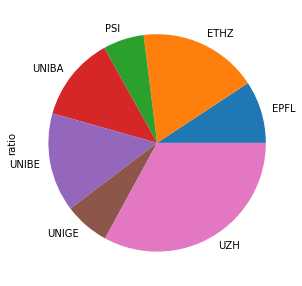

In [28]:
# Visualisation of the final results
%matplotlib inline
df_institutions_pie = df_institutions_mapped.set_index('acronym')
import matplotlib.pyplot as plt
df_institutions_pie.plot.pie(y='ratio', figsize=(5, 5), legend=False)

## Final exports

In [29]:
# 1) export of ratios by institution
if (results_ratios.endswith('tsv')):
    df_institutions_mapped_new.to_csv(results_ratios, sep='\t', header=True, index=False)
if (results_ratios.endswith('xlsx')):
    df_institutions_mapped_new.to_excel(results_ratios, header=True, index=False)

In [30]:
# 2) export of publications by institutions
if (publications_by_institution.endswith('tsv')):
    df_publications_by_institution.to_csv(publications_by_institution, sep='\t', header=True, index=False)
if (affiliations_not_mapped.endswith('xlsx')):
    df_publications_by_institution.to_excel(publications_by_institution, header=True, index=False)

In [31]:
# 3) export list of affiliations not mapped
if (do_map == 1):
    aff_not_mapped_country = df_affiliations.loc[(df_affiliations['acronym'] == 'NOT MAPPED') & (df_affiliations['affiliation_country'] == country)]
    aff_not_mapped_country = aff_not_mapped_country[['publication_id', 'affiliation_value', 'acronym']]
    aff_not_mapped_country['acronym'] = ''
    nb_not_mapped = str(aff_not_mapped_country.shape[0])
    # drop duplicates
    aff_not_mapped_country = aff_not_mapped_country.drop_duplicates()
    # sort by affiliation value
    aff_not_mapped_country = aff_not_mapped_country.sort_values(by=['affiliation_value'])
    # export on xlsx or tsv file depending on file type
    if (affiliations_not_mapped.endswith('tsv')):
        aff_not_mapped_country.to_csv(affiliations_not_mapped, sep='\t', header=True, index=False)
    if (affiliations_not_mapped.endswith('xlsx')):
        aff_not_mapped_country.to_excel(affiliations_not_mapped, header=True, index=False)
    print('Affiliations that were not mapped: ' + str(aff_not_mapped_country.shape[0]))
    print('Number of occurrences of these affiliations: ' + nb_not_mapped)
    print('*** Please consider adding these items in the mapping file \'' + mapping_file + '\' and re-run the script. ***')

Affiliations that were not mapped: 10
Number of occurrences of these affiliations: 12
*** Please consider adding these items in the mapping file 'affiliations_mapping.xlsx' and re-run the script. ***


In [32]:
aff_not_mapped_country

,publication_id,affiliation_value,acronym
5036,80417,"Department of Fundamental Microbiology, Facult...",
6197,84281,"Hochschule Luzern, Luzern, 6002, Switzerland",
3819,79839,"Physik-Institut, Universitat Zurich, Winterthu...",
6121,82510,"Physik-Institut, Universität Zürich, Winterthu...",
6125,82511,"Physik-Institut, Universität Zürich, Winterthu...",
1016,76800,"Physik-Institut, Universität Zürich, Winterthu...",
3712,79662,"Physik-Institut, Universität Zürich, Winterthu...",
6087,82261,"Physik-Institut, Universität Zürich, Winterthu...",
5824,81982,"Prescient Design, gRED, Roche, 2807 Basel, Swi...",
982,76648,"SwissScientific Technologies SA, rue du Rhone ...",
